In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Enable inline plotting (if using Jupyter)
%matplotlib inline
sns.set_palette(sns.color_palette("husl", 8))

# === CONFIGURATION ===
base_matrix_path = '/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork'
csv_base_path    = os.path.join(base_matrix_path, 'datasets')
output_base_path = '/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/Result1_R1_AllModels'

# Map each model’s folder name → exact suffix in their .npy filenames
model_paths_and_suffixes = {
    'DNA_BERT2':                         'DB2_Embeddings',
    'HyenaDNA':                          'HD_Embeddings',
    'mistral':                           'mistral_Embeddings',
    'nucleotide-transformer-500m-human-ref': 'NT_Embeddings',
    'genalm':                            'GENALM_Embeddings',
    'grover':                            'GROVER_Embeddings'
}

# Each dataset key → [train CSV name, test CSV name]
datasets = {
    'demo_coding_vs_intergenomic': [
        'train_demo_coding_vs_intergenomic_seqs.csv',
        'test_demo_coding_vs_intergenomic_seqs.csv'
    ],
    'human_enhancers_cohn': [
        'train_human_enhancers_cohn.csv',
        'test_human_enhancers_cohn.csv'
    ],
    'human_enhancers_ensembl': [
        'train_human_enhancers_ensembl.csv',
        'test_human_enhancers_ensembl.csv'
    ],
    'human_nontata_promoters': [
        'train_human_nontata_promoters.csv',
        'test_human_nontata_promoters.csv'
    ]
}

# === HELPER FUNCTIONS ===

def combine_train_test(matrices, train_file, test_file):
    """Vertically stack the train and test embedding matrices."""
    return np.vstack((matrices[train_file], matrices[test_file]))

def calculate_column_wise_correlation(matrix):
    """Return the column-wise correlation matrix of `matrix`."""
    return np.corrcoef(matrix.T)

def flatten_correlation_matrix(corr_matrix):
    """Extract the strictly upper-triangle entries (k=1) from `corr_matrix`."""
    idx = np.triu_indices_from(corr_matrix, k=1)
    return corr_matrix[idx]

def load_embeddings(folder_path, suffix):
    """
    Load all .npy files in `folder_path` whose filename contains `suffix`.
    Special-case:
      - If folder_path ends with 'nucleotide-transformer-500m-human-ref', load as np.matrix.
      - Otherwise, load via np.vstack(np.array(...)).
    Returns dict: filename → 2D NumPy array.
    """
    matrices = {}
    if not os.path.exists(folder_path):
        print(f"[Warning] Folder not found: {folder_path}")
        return matrices

    is_nt = folder_path.endswith('nucleotide-transformer-500m-human-ref')

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.npy') and suffix in file_name:
            path = os.path.join(folder_path, file_name)
            try:
                raw = np.load(path, allow_pickle=True)
                if is_nt:
                    # For NT folder, wrap in np.matrix
                    matrices[file_name] = np.matrix(raw)
                else:
                    # For all others, ensure a 2D array via vstack
                    matrices[file_name] = np.vstack(np.array(raw))
                print(f"[Loaded] {file_name} → shape: {matrices[file_name].shape}")
            except Exception as e:
                print(f"[Error] Failed to load {file_name}: {e}")

    return matrices

# === MAIN PROCESSING FUNCTION ===

def process_model_embeddings(model_folder, suffix):
    """
    1. Load embeddings (.npy) from model_folder where filenames contain `suffix`.
       - If folder is NT, load via np.matrix(...)
       - Otherwise, load via np.vstack(np.array(...))
    2. Combine train/test embeddings for each dataset key.
    3. Load + concatenate train/test CSVs of labels.
    4. Run PCA on each combined embedding; save scatter plots and a CSV of explained variance.
    5. Compute pairwise column-wise correlations; for each dataset:
         • Save the full 768×768 correlation matrix as CSV
         • Compute mean & SD of upper-triangle correlations, then save and print summary.
    """
    print(f"\n=== Processing {model_folder} ===")
    folder_path = os.path.join(base_matrix_path, model_folder)
    output_path = os.path.join(output_base_path, model_folder)
    os.makedirs(output_path, exist_ok=True)

    # Step 1: Load embeddings
    matrices = load_embeddings(folder_path, suffix)
    if not matrices:
        print(f"[Skip] No embeddings found in '{model_folder}' matching '{suffix}'.")
        return

    # Step 2a: Combine train/test embeddings
    combined_matrices = {}
    for key in datasets:
        if 'coding' in key:
            train_key = f"train_{key}_seqs_{suffix}.npy"
            test_key  = f"test_{key}_seqs_{suffix}.npy"
        else:
            train_key = f"train_{key}_{suffix}.npy"
            test_key  = f"test_{key}_{suffix}.npy"

        if train_key in matrices and test_key in matrices:
            combined_matrices[key] = combine_train_test(matrices, train_key, test_key)
        else:
            missing = []
            if train_key not in matrices:
                missing.append(train_key)
            if test_key not in matrices:
                missing.append(test_key)
            print(f"[Warning] Missing embeddings for '{key}' in '{model_folder}': {', '.join(missing)}")

    # Step 2b: Load + concatenate labels CSVs
    combined_dfs = {}
    for key, (train_csv, test_csv) in datasets.items():
        train_path = os.path.join(csv_base_path, train_csv)
        test_path  = os.path.join(csv_base_path, test_csv)
        if os.path.exists(train_path) and os.path.exists(test_path):
            df_train = pd.read_csv(train_path)
            df_test  = pd.read_csv(test_path)
            combined_dfs[key] = pd.concat([df_train, df_test], axis=0, ignore_index=True)
        else:
            missing = []
            if not os.path.exists(train_path):
                missing.append(train_path)
            if not os.path.exists(test_path):
                missing.append(test_path)
            print(f"[Error] CSV not found for '{key}': {', '.join(missing)}")

    # Step 3: PCA scatter plots + collect explained variance
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes = axes.flatten()
    variance_records = []

    for idx, (key, emb_matrix) in enumerate(combined_matrices.items()):
        if key not in combined_dfs:
            print(f"[Skip] No labels DataFrame for '{key}' in '{model_folder}'.")
            continue

        labels_df = combined_dfs[key]
        if emb_matrix.shape[0] != len(labels_df):
            print(f"[Mismatch] '{model_folder}' → '{key}': "
                  f"{emb_matrix.shape[0]} embeddings vs {len(labels_df)} labels. Skipping PCA.")
            continue

        emb_array = np.asarray(emb_matrix)
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(emb_array)

        pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
        pca_df['label'] = labels_df['label']

        sns.scatterplot(
            data=pca_df,
            x='PCA1', y='PCA2',
            hue='label',
            alpha=0.8,
            ax=axes[idx]
        )
        axes[idx].set_title(f'PCA of {key}')

        variance_records.append({
            'Dataset': key,
            'PCA1 Variance': pca.explained_variance_ratio_[0],
            'PCA2 Variance': pca.explained_variance_ratio_[1],
            'Total Variance (Top 2 PCs)': sum(pca.explained_variance_ratio_[:2])
        })

    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f'PCA_scatter_{suffix}_R1.pdf'))
    plt.close()

    # Step 3b: Save explained-variance CSV + barplot
    var_df = pd.DataFrame(variance_records)
    if not var_df.empty:
        var_df.to_csv(os.path.join(output_path, f'pca_variance_{suffix}_R1.csv'), index=False)

        var_melt = var_df.melt(
            id_vars=['Dataset'],
            value_vars=['PCA1 Variance', 'PCA2 Variance'],
            var_name='PCA Component',
            value_name='Variance Explained'
        )
        plt.figure(figsize=(12, 8))
        sns.barplot(
            data=var_melt,
            x='Variance Explained',
            y='Dataset',
            hue='PCA Component'
        )
        plt.title(f'{model_folder}: Variance Explained by PCA1 & PCA2')
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, f'PCA_variance_bar_{suffix}_R1.pdf'))
        plt.close()
    else:
        print(f"[Warning] No PCA variance data for '{model_folder}'")

    # Step 4: Compute column-wise correlations; save full matrix + summarize mean & SD
    summary_records = []
    for key, emb_matrix in combined_matrices.items():
        if key not in combined_dfs or emb_matrix.shape[0] != len(combined_dfs[key]):
            continue

        corr_mat = calculate_column_wise_correlation(emb_matrix)

        # Save full 768×768 correlation matrix as CSV
        corr_full_df = pd.DataFrame(
            corr_mat,
            index=[f"dim_{i}" for i in range(corr_mat.shape[0])],
            columns=[f"dim_{j}" for j in range(corr_mat.shape[1])]
        )
        corr_full_df.to_csv(
            os.path.join(output_path, f'{key}_full_corr_matrix_{suffix}_R1.csv'),
            index=True
        )

        # Flatten for summary
        flattened = flatten_correlation_matrix(corr_mat)
        mean_corr = np.mean(flattened)
        sd_corr   = np.std(flattened)

        summary_records.append({
            'Model': model_folder,
            'Dataset': key,
            'Mean Correlation': mean_corr,
            'SD Correlation': sd_corr
        })

    # Convert summary to DataFrame, save, and print
    if summary_records:
        summary_df = pd.DataFrame(summary_records)
        summary_csv_path = os.path.join(output_path, f'correlation_summary_{suffix}_R1.csv')
        summary_df.to_csv(summary_csv_path, index=False)

        print(f"\nCorrelation summary for model '{model_folder}':")
        print(summary_df.to_string(index=False))
    else:
        print(f"[Warning] No correlation summary data for '{model_folder}'")

    # Finally, print PCA variance summary if available
    if not var_df.empty:
        print(f"\nVariance summary ({model_folder}):")
        print(var_df[['Dataset', 'Total Variance (Top 2 PCs)']].to_string(index=False))
    print(f"✓ Completed processing '{model_folder}'")


# === EXECUTE FOR ALL MODELS ===
for model_folder, suffix in model_paths_and_suffixes.items():
    process_model_embeddings(model_folder, suffix)



=== Processing DNA_BERT2 ===
[Loaded] test_demo_coding_vs_intergenomic_seqs_DB2_Embeddings.npy → shape: (25000, 768)
[Loaded] test_human_enhancers_cohn_DB2_Embeddings.npy → shape: (6948, 768)
[Loaded] test_human_enhancers_ensembl_DB2_Embeddings.npy → shape: (30970, 768)
[Loaded] test_human_ensembl_regulatory_DB2_Embeddings.npy → shape: (57713, 768)
[Loaded] test_human_nontata_promoters_DB2_Embeddings.npy → shape: (9034, 768)
[Loaded] test_human_ocr_ensembl_DB2_Embeddings.npy → shape: (34952, 768)
[Loaded] train_demo_coding_vs_intergenomic_seqs_DB2_Embeddings.npy → shape: (75000, 768)
[Loaded] train_human_enhancers_cohn_DB2_Embeddings.npy → shape: (20843, 768)
[Loaded] train_human_enhancers_ensembl_DB2_Embeddings.npy → shape: (123872, 768)
[Loaded] train_human_ensembl_regulatory_DB2_Embeddings.npy → shape: (231348, 768)
[Loaded] train_human_nontata_promoters_DB2_Embeddings.npy → shape: (27097, 768)
[Loaded] train_human_ocr_ensembl_DB2_Embeddings.npy → shape: (139804, 768)

Correlation 

In [26]:
### Effective Dimensionality

In [25]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# === CONFIGURATION ===
base_matrix_path = '/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork'
output_path = os.path.join(base_matrix_path, 'effective_dimension_results.csv')

# Folder and suffix for each model
model_paths_and_suffixes = {
    'DNA_BERT2':                         'DB2_Embeddings',
    'HyenaDNA':                          'HD_Embeddings',
    'mistral':                           'mistral_Embeddings',
    'nucleotide-transformer-500m-human-ref': 'NT_Embeddings',
    'genalm':                            'GENALM_Embeddings',
    'grover':                            'GROVER_Embeddings'
}

# Effective dimensionality threshold
threshold = 0.95

# Collect results
records = []

# Compute effective dimensionality
for model_folder, suffix in model_paths_and_suffixes.items():
    folder_path = os.path.join(base_matrix_path, model_folder)
    if not os.path.exists(folder_path):
        continue

    for file in os.listdir(folder_path):
        if file.endswith('.npy') and suffix in file and file.startswith('train_'):
            file_path = os.path.join(folder_path, file)
            try:
                data = np.load(file_path, allow_pickle=True)
                if model_folder == 'nucleotide-transformer-500m-human-ref':
                    data = np.asarray(data)
                else:
                    data = np.vstack(np.array(data))

                pca = PCA()
                pca.fit(data)
                cum_var = np.cumsum(pca.explained_variance_ratio_)
                k = np.argmax(cum_var >= threshold) + 1

                records.append({
                    'Model': model_folder,
                    'Dataset': file.replace('.npy', ''),
                    'Effective_Dim_k': k,
                    'Embedding_Dim': data.shape[1],
                    'Ratio': round(k / data.shape[1], 4)
                })
            except Exception as e:
                print(f"Failed: {file} | Error: {str(e)}")

# Save results
results_df = pd.DataFrame(records)

In [27]:
results_df

,Model,Dataset,Effective_Dim_k,Embedding_Dim,Ratio
0,DNA_BERT2,train_demo_coding_vs_intergenomic_seqs_DB2_Emb...,385,768,0.5013
1,DNA_BERT2,train_human_enhancers_cohn_DB2_Embeddings,247,768,0.3216
2,DNA_BERT2,train_human_enhancers_ensembl_DB2_Embeddings,335,768,0.4362
3,DNA_BERT2,train_human_ensembl_regulatory_DB2_Embeddings,309,768,0.4023
4,DNA_BERT2,train_human_nontata_promoters_DB2_Embeddings,347,768,0.4518
5,DNA_BERT2,train_human_ocr_ensembl_DB2_Embeddings,340,768,0.4427
6,HyenaDNA,train_demo_coding_vs_intergenomic_seqs_HD_Embe...,42,256,0.1641
7,HyenaDNA,train_human_enhancers_cohn_HD_Embeddings,36,256,0.1406
8,HyenaDNA,train_human_enhancers_ensembl_HD_Embeddings,29,256,0.1133
9,HyenaDNA,train_human_ensembl_regulatory_HD_Embeddings,27,256,0.1055


In [29]:
results_df.to_csv('/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/Result1_R1_AllModels/effective_dimension_results.csv', index=False)

Plot saved to: /mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/Result1_R1_AllModels/violin_grid_correlation_plot.pdf


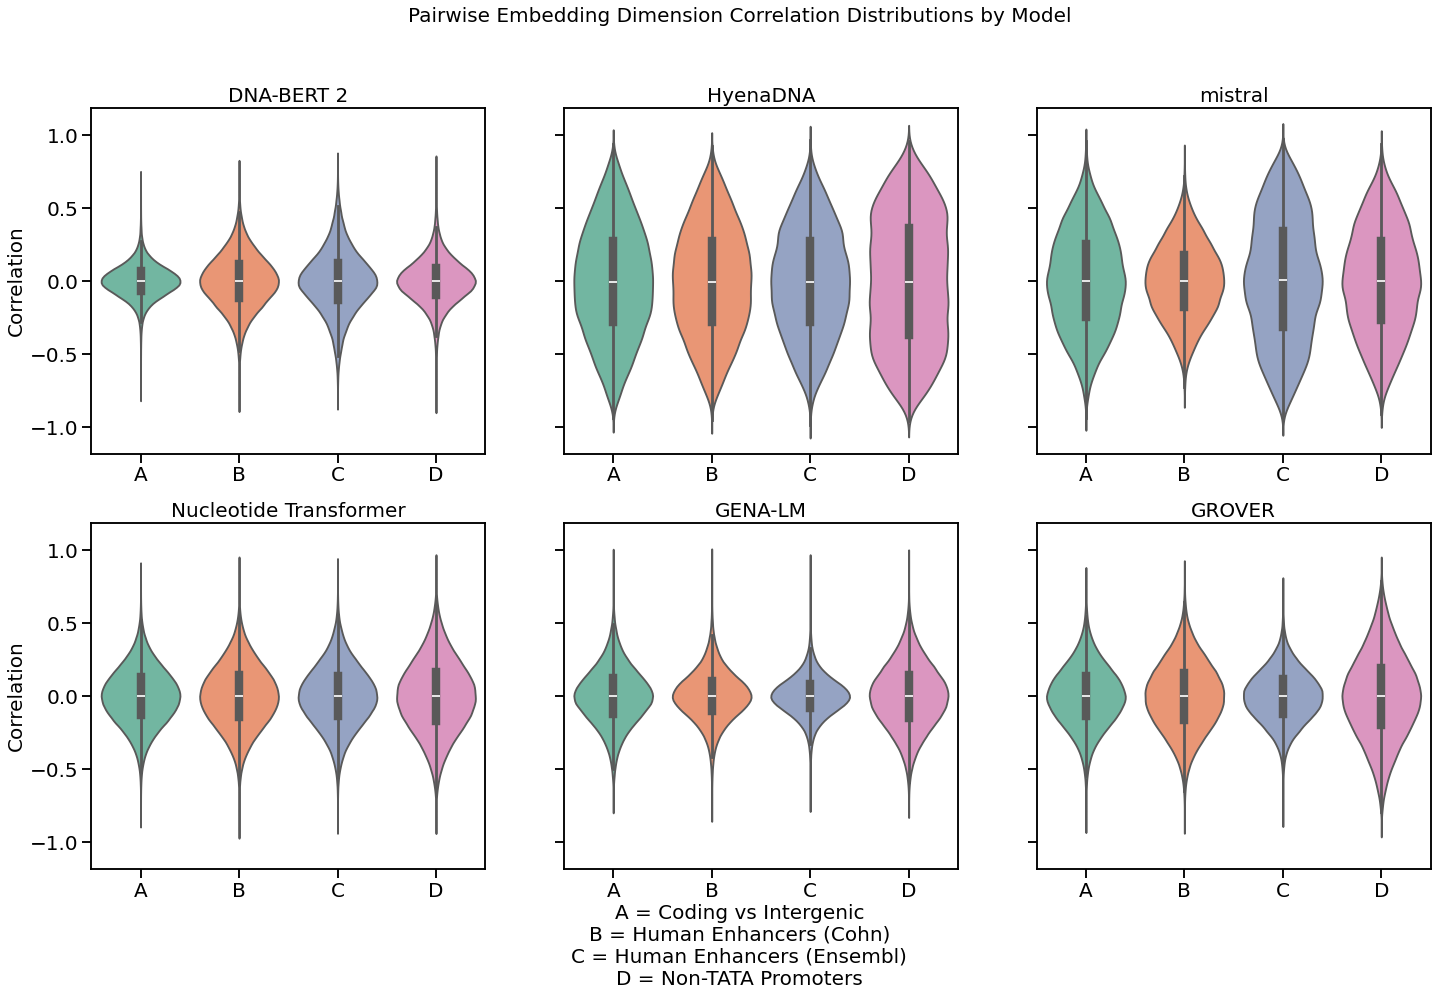

In [69]:
%matplotlib inline

import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

# === SUPPRESS WARNINGS ===
warnings.filterwarnings("ignore")

# === CONFIGURATION ===
output_base_path = '/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/Result1_R1_AllModels'
save_path = os.path.join(output_base_path, 'violin_grid_correlation_plot.pdf')

# Internal model folder to suffix
model_paths_and_suffixes = {
    'DNA_BERT2':                         'DB2_Embeddings',
    'HyenaDNA':                          'HD_Embeddings',
    'mistral':                           'mistral_Embeddings',
    'nucleotide-transformer-500m-human-ref': 'NT_Embeddings',
    'genalm':                            'GENALM_Embeddings',
    'grover':                            'GROVER_Embeddings'
}

# Pretty display names for plot titles
model_display_names = {
    'DNA_BERT2': 'DNA-BERT 2',
    'HyenaDNA': 'HyenaDNA',
    'mistral': 'mistral',
    'nucleotide-transformer-500m-human-ref': 'Nucleotide Transformer',
    'genalm': 'GENA-LM',
    'grover': 'GROVER'
}

# Dataset letter mapping
dataset_mapping = {
    'demo_coding_vs_intergenomic': 'A',
    'human_enhancers_cohn':        'B',
    'human_enhancers_ensembl':     'C',
    'human_nontata_promoters':     'D'
}

# Full label legend for datasets
dataset_legend = {
    'A': 'Coding vs Intergenic',
    'B': 'Human Enhancers (Cohn)',
    'C': 'Human Enhancers (Ensembl)',
    'D': 'Non-TATA Promoters'
}

def flatten_corr_matrix(df):
    """Return upper triangle values (excluding diagonal) from a square DataFrame."""
    matrix = df.values.astype(float)
    i_upper = np.triu_indices_from(matrix, k=1)
    return matrix[i_upper]

# === COLLECT DATA FROM ALL _full_corr_matrix_ FILES ===
records = []

for model_folder, suffix in model_paths_and_suffixes.items():
    folder_path = os.path.join(output_base_path, model_folder)
    file_pattern = os.path.join(folder_path, f'*_full_corr_matrix_{suffix}_R1.csv')
    corr_files = glob.glob(file_pattern)

    for file_path in corr_files:
        dataset_key = os.path.basename(file_path).split('_full_corr_matrix_')[0]
        dataset_short = dataset_mapping.get(dataset_key, dataset_key)
        try:
            corr_df = pd.read_csv(file_path, index_col=0)
            flattened_values = flatten_corr_matrix(corr_df)

            records.extend({
                'Model': model_folder,
                'Dataset': dataset_short,
                'Correlation': val
            } for val in flattened_values)
        except Exception:
            continue  # Skip problematic files silently

# === CREATE DATAFRAME FOR PLOTTING ===
full_corr_df = pd.DataFrame(records)

# === PLOT 2x3 GRID OF VIOLIN PLOTS ===
model_order = list(model_paths_and_suffixes.keys())
palette = sns.color_palette("Set2")

sns.set_context("talk", font_scale=2.0)
fig, axes = plt.subplots(2, 3, figsize=(24, 14), sharey=True)
axes = axes.flatten()

for idx, model in enumerate(model_order):
    model_df = full_corr_df[full_corr_df['Model'] == model]

    sns.violinplot(
        data=model_df,
        x='Dataset',
        y='Correlation',
        palette=palette,
        ax=axes[idx],
        inner='box'
    )
    title = model_display_names.get(model, model)
    axes[idx].set_title(title, fontsize=20)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Correlation', fontsize=20)
    axes[idx].tick_params(axis='x', labelsize=20, rotation=0)
    axes[idx].tick_params(axis='y', labelsize=20)

# Remove any unused subplots
for ax in axes[len(model_order):]:
    fig.delaxes(ax)

# === Add Dataset Legend at the Bottom ===
legend_text = '\n'.join([f"{k} = {v}" for k, v in dataset_legend.items()])
fig.text(0.5, 0.01, legend_text, ha='center', fontsize=20)

fig.suptitle("Pairwise Embedding Dimension Correlation Distributions by Model", fontsize=20)
plt.tight_layout(rect=[0, 0.05, 0.05, 0.05])

# === Save plot ===
plt.savefig(save_path, bbox_inches='tight')
print(f"Plot saved to: {save_path}")

# === Display plot ===
plt.show()


Plot saved to: /mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/Result1_R1_AllModels/pca_variance_radar_plot.pdf


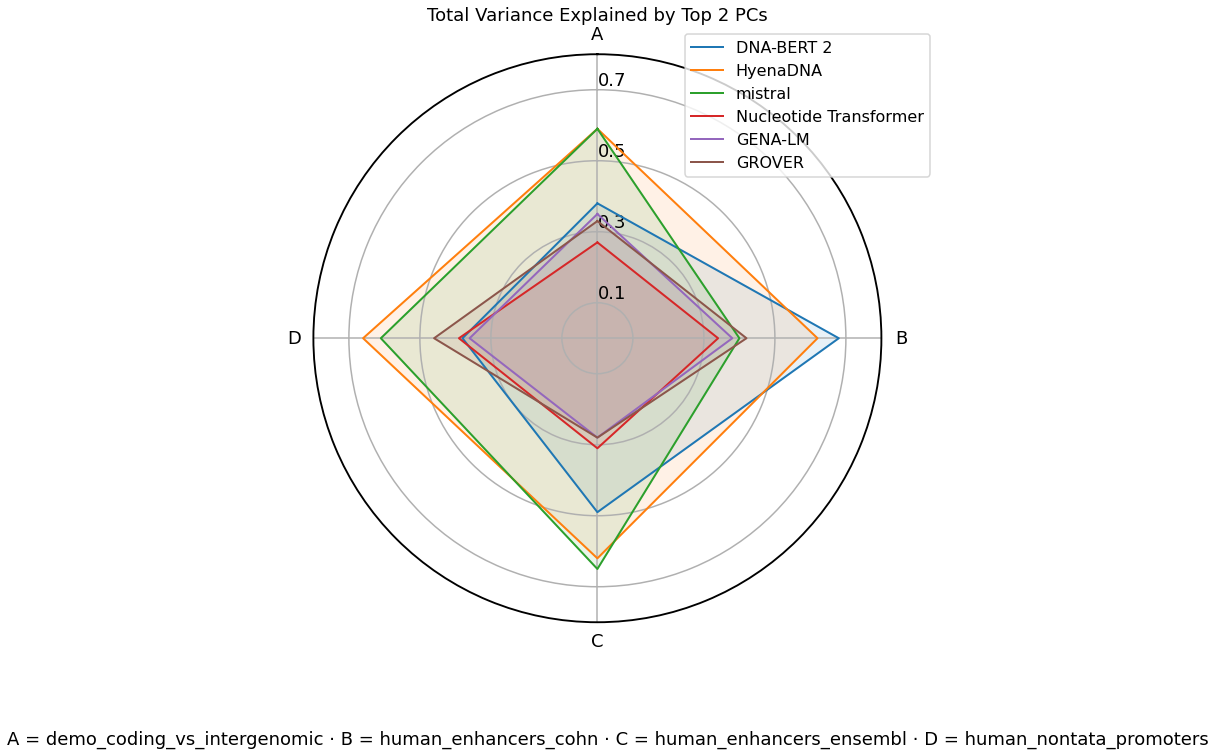

In [66]:
import os
import matplotlib.pyplot as plt
import numpy as np

# === Ensure the output directory exists ===
output_dir = "/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/Result1_R1_AllModels"
os.makedirs(output_dir, exist_ok=True)

# === PCA Variance Data for Each Model ===
pca_variance_data = {
    'DNA-BERT 2': [0.38, 0.68, 0.49, 0.38],
    'HyenaDNA': [0.59, 0.62, 0.62, 0.66],
    'mistral': [0.59, 0.40, 0.65, 0.61],
    'Nucleotide Transformer': [0.27, 0.34, 0.31, 0.39],
    'GENA-LM': [0.35, 0.38, 0.28, 0.36],
    'GROVER': [0.33, 0.42, 0.28, 0.46]
}

axis_labels = ['A', 'B', 'C', 'D']
axis_legend = {
    'A': 'demo_coding_vs_intergenomic',
    'B': 'human_enhancers_cohn',
    'C': 'human_enhancers_ensembl',
    'D': 'human_nontata_promoters'
}

# === Angle setup for radar chart ===
num_vars = len(axis_labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# === Create Radar Plot ===
fig, ax = plt.subplots(figsize=(10, 11), subplot_kw=dict(polar=True))
colors = plt.cm.tab10.colors

# Plot each model’s PCA variance profile
for idx, (model, values) in enumerate(pca_variance_data.items()):
    color = colors[idx % len(colors)]
    values += values[:1]
    ax.plot(angles, values, label=model, color=color, linewidth=2)
    ax.fill(angles, values, color=color, alpha=0.1)

# Formatting
ax.set_title("Total Variance Explained by Top 2 PCs", size=18, pad=5)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), axis_labels, fontsize=18)
ax.set_ylim(0, 0.8)
ax.tick_params(axis='y', labelsize=18, pad=8)
ax.set_rlabel_position(0)
ax.set_rgrids(np.arange(0.1, 0.9, 0.2), angle=0, fontsize=18)

legend_text = " · ".join([f"{k} = {v}" for k, v in axis_legend.items()])
plt.figtext(0.5, 0.015, legend_text, ha='center', fontsize=18)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05), fontsize=16)

plt.tight_layout(rect=[0, 0.08, 1, 1])

# ✅ Save before plt.show()
output_path = os.path.join(output_dir, "pca_variance_radar_plot.pdf")
plt.savefig(output_path, bbox_inches='tight')
print(f"Plot saved to: {output_path}")

plt.show()
